In [1]:
import os
import math
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pyproj import CRS
from shapely import box

import autoroot
from rs_tools._src.geoprocessing.goes.reproject import add_goes16_crs
from rs_tools._src.geoprocessing.msg.reproject import add_msg_crs
from rs_tools._src.geoprocessing.interp import resample_rioxarray

/opt/conda/envs/rs_tools/lib/python3.11/site-packages/goes2go/data.py:519: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),
/opt/conda/envs/rs_tools/lib/python3.11/site-packages/goes2go/NEW.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),


#### TO DISCUSS:

- When comparing tiles, do we want to project into an arbitrary refernce frame?
    - If yes, what resoltion should we choose?

##### Load xarray datasets

In [2]:
goes_band = 14 # IR 12.3 um
msg_band = 5 # IR 12 um

In [3]:
goes_path = '/mnt/disks/goes-data/goes/'
msg_path = '/mnt/disks/msg-data/msg/'

In [82]:
msg_files = [os.path.join(msg_path, f) for f in os.listdir(msg_path) if f.endswith('.nc')]
msg_files.sort()
msg_file = msg_files[1]
print(msg_file)

goes_files = [os.path.join(goes_path, f) for f in os.listdir(goes_path) if f.endswith('.nc')]
goes_files.sort()
goes_file = goes_files[0]
print(goes_file)

/mnt/disks/msg-data/msg/20200101005743_msg.nc
/mnt/disks/goes-data/goes/20200101010021_goes16.nc


In [83]:
msg_ds = xr.open_dataset(msg_file)
goes_ds = xr.open_dataset(goes_file)

In [116]:
msg_ds

<xarray.Dataset> Size: 717MB
Dimensions:             (y: 3712, x: 3712, band: 11, time: 1,
                         band_wavelength: 11)
Coordinates:
  * y                   (y) float64 30kB -5.566e+06 -5.563e+06 ... 5.569e+06
  * x                   (x) float64 30kB 5.566e+06 5.563e+06 ... -5.569e+06
  * band                (band) <U6 264B 'IR_016' 'IR_039' ... 'WV_062' 'WV_073'
  * time                (time) <U19 76B '2020-01-01 00:45:00'
  * band_wavelength     (band_wavelength) float64 88B 1.64 3.92 ... 6.25 7.35
    msg_seviri_fes_3km  int64 8B 0
Data variables:
    cloud_mask          (y, x) float64 110MB 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
    Rad                 (band, y, x) float32 606MB nan nan nan ... nan nan nan
Attributes:
    calibration:         radiance
    standard_name:       toa_outgoing_radiance_per_unit_wavenumber
    platform_name:       Meteosat-11
    sensor:              seviri
    units:               mW m-2 sr-1 (cm-1)-1
    orbital_parameters:  {"projection_longitude": 0.0, "projection_latitude":...

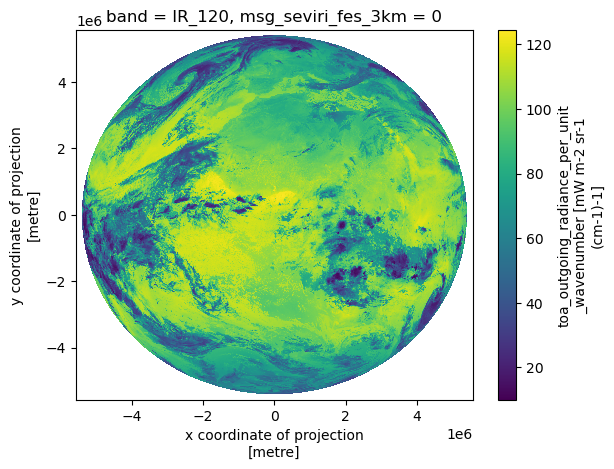

In [119]:
msg_ds.Rad.isel(band=msg_band).plot()

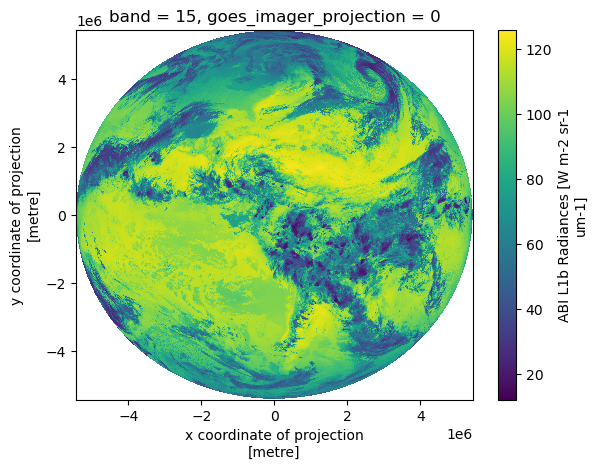

In [118]:
goes_ds.Rad.isel(band=goes_band).plot()

#### Reset coordinates to variables and remove latitude/longitude so that the reprojection works.

In [84]:
# Move specific coordinate variables to data variables
goes_ds = goes_ds.reset_coords(["cloud_mask"])
goes_ds = goes_ds.drop_vars(["latitude", "longitude"])

goes_ds = add_goes16_crs(goes_ds)

goes_ds.rio.set_spatial_dims(
    x_dim="x",
    y_dim="y",
    inplace=True,
).rio.write_coordinate_system(inplace=True);

In [14]:
goes_ds["cloud_mask"].values

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [55]:
np.isnan(goes_ds["cloud_mask"]).values

array([[False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

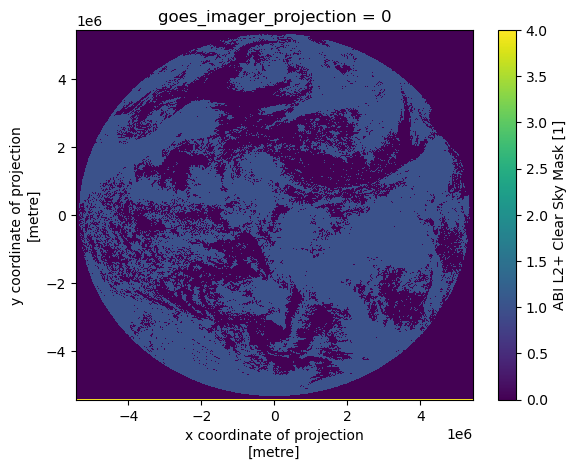

In [59]:
goes_ds["cloud_mask"].fillna(4).plot()

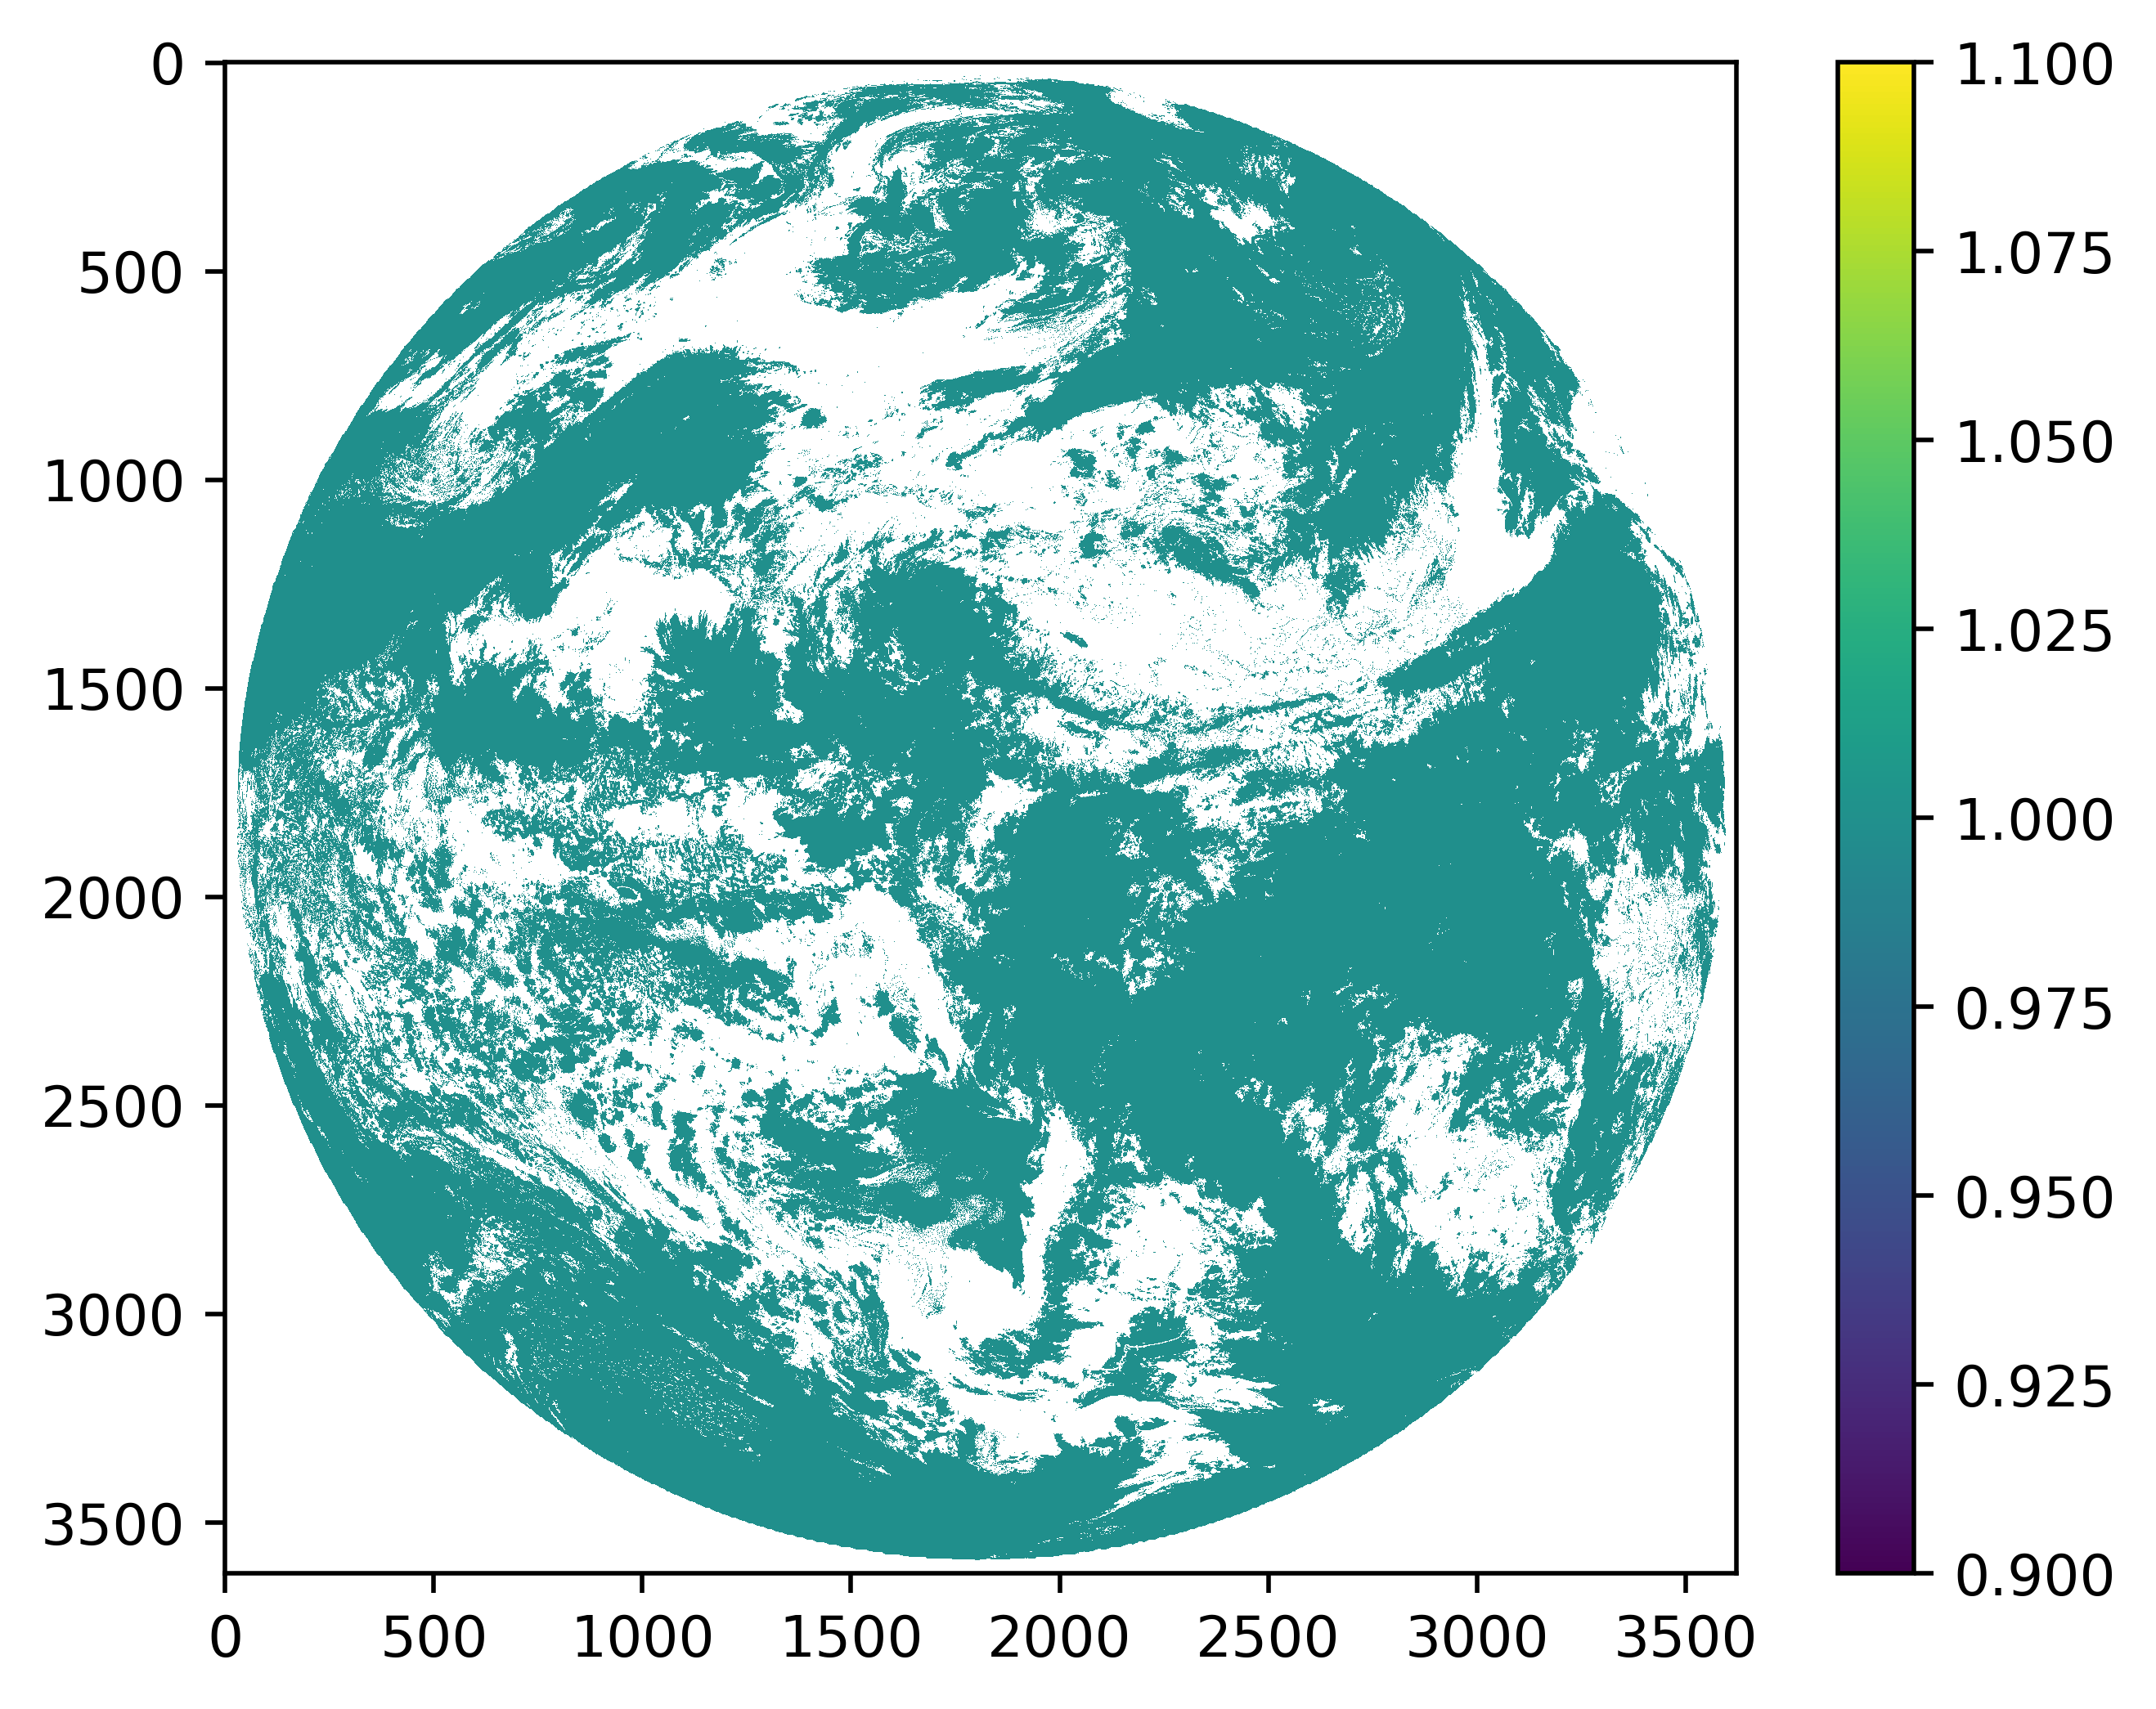

In [78]:
plt.figure(dpi=500)
plt.imshow(goes_ds["cloud_mask"].where(goes_ds["cloud_mask"] == 1), interpolation='none')
plt.colorbar()
# plt.imshow(goes_ds["cloud_mask"].where(goes_ds["cloud_mask"] > 0), interpolation='none')
# plt.colorbar()
# plt.imshow(goes_ds["cloud_mask"].fillna(4).where(goes_ds["cloud_mask"].fillna(4) == 4), interpolation='none')
# plt.colorbar()
# plt.imshow(np.isnan(goes_ds["cloud_mask"]))

# plt.figure()
# plt.imshow(goes_ds["cloud_mask"].values[1500:2000, 1500:2000])
# plt.colorbar()

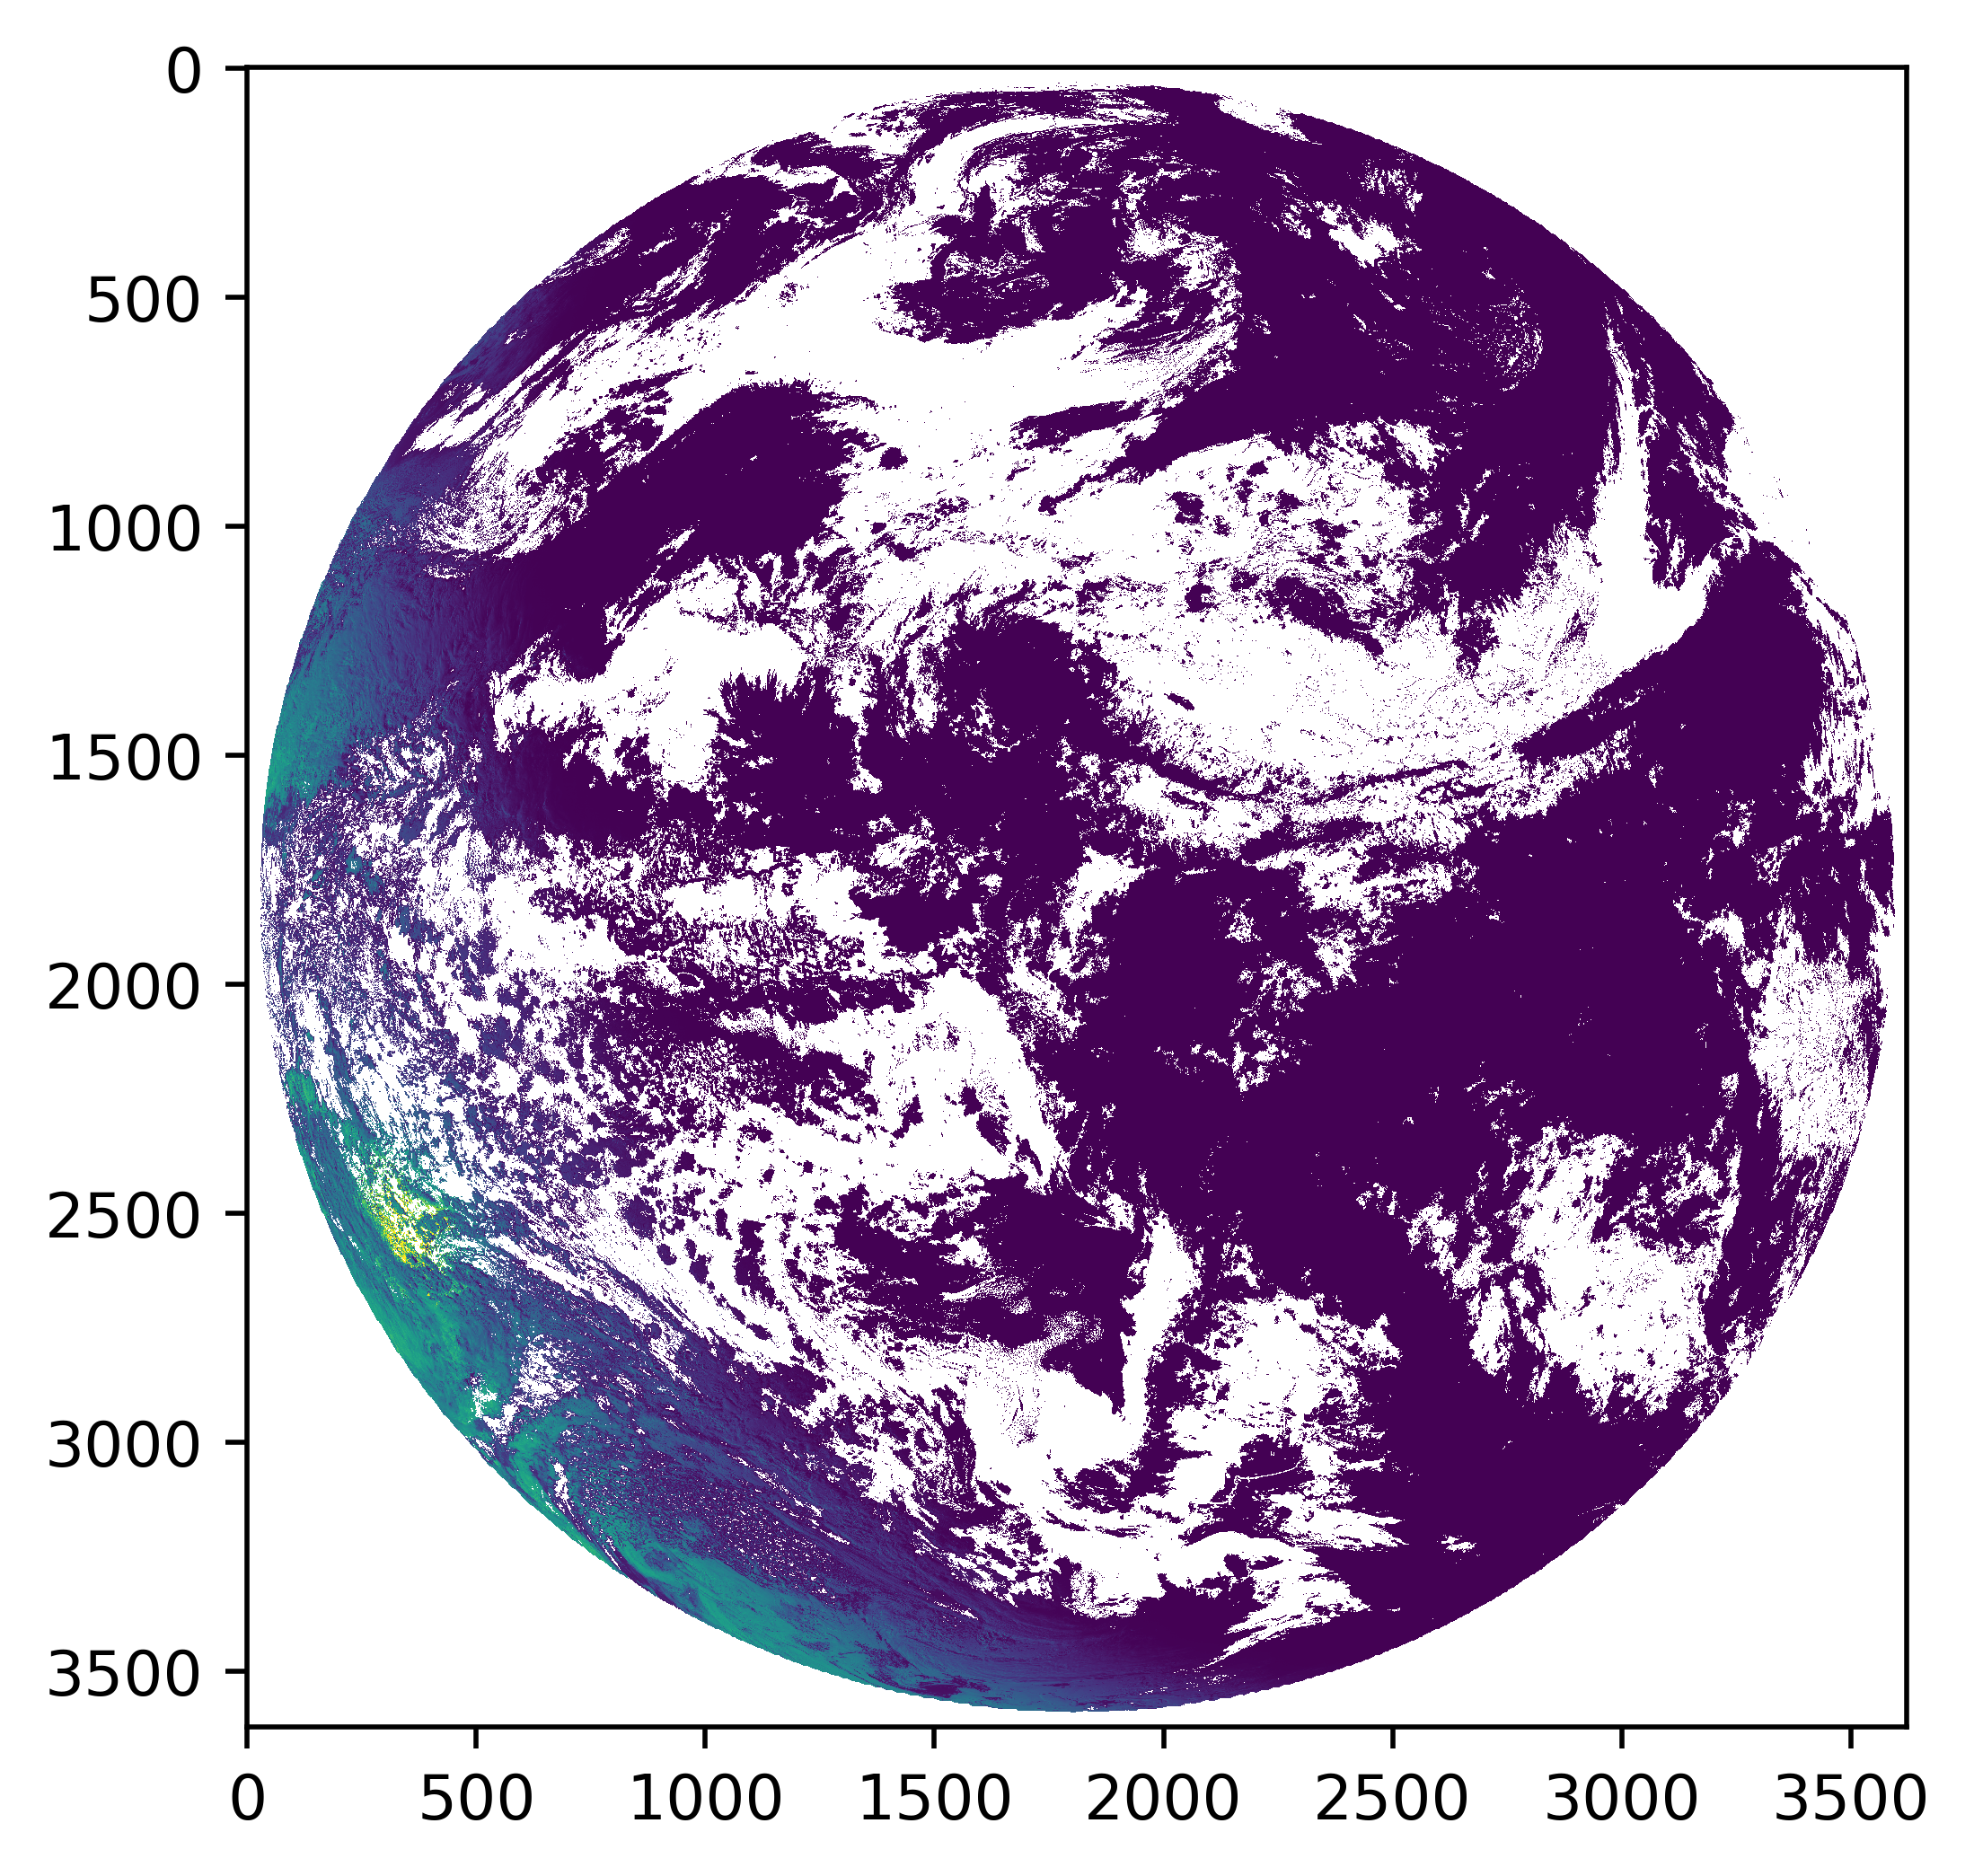

In [80]:
plt.figure(dpi=500)
plt.imshow(goes_ds.Rad.isel(band=2).where(goes_ds["cloud_mask"] == 1), interpolation='none')

In [85]:
# Move specific coordinate variables to data variables
msg_ds = msg_ds.reset_coords(["cloud_mask"])
msg_ds = msg_ds.drop_vars(["latitude", "longitude"])

msg_ds = add_msg_crs(msg_ds)

msg_ds.rio.set_spatial_dims(
    x_dim="x",
    y_dim="y",
    inplace=True,
).rio.write_coordinate_system(inplace=True);

## Reproject GOES/MSG

#### Add Coordinate Reference Systems

In [88]:
msg_ds = add_msg_crs(msg_ds)
goes_ds = add_goes16_crs(goes_ds)

#### Reproject to an arbitrary coordinate reference frame

In [27]:
def meters_to_degrees(resolution_in_meters, latitude):
    # Convert latitude resolution
    resolution_in_degrees_lat = resolution_in_meters / 111000
    
    # Convert longitude resolution
    resolution_in_degrees_lon = resolution_in_meters / (111000 * math.cos(math.radians(latitude)))
    
    return resolution_in_degrees_lat, resolution_in_degrees_lon

# Example usage
resolution_in_meters = 3_000.4  # 5 kilometers
latitude = 0  # Example latitude

resolution_in_degrees = meters_to_degrees(resolution_in_meters, latitude)
resolution_in_degrees

(0.02703063063063063, 0.02703063063063063)

In [89]:
from pyproj import CRS

dst_crs = CRS.from_epsg(4326)  # WGS 84
dst_resolution = 0.027 # in your destination units, in this case degrees

In [90]:
goes_ds_reproject = goes_ds.rio.reproject(dst_crs=dst_crs, resolution=dst_resolution)
goes_ds_reproject

<xarray.Dataset> Size: 2GB
Dimensions:                 (x: 6014, y: 5529, band: 16)
Coordinates:
  * x                       (x) float64 48kB -156.3 -156.2 ... 6.049 6.076
  * y                       (y) float64 44kB 74.6 74.57 74.55 ... -74.63 -74.65
  * band                    (band) int64 128B 1 2 3 4 5 6 ... 11 12 13 14 15 16
    goes_imager_projection  int64 8B 0
Data variables:
    Rad                     (band, y, x) float32 2GB nan nan nan ... nan nan nan
    cloud_mask              (y, x) float64 266MB nan nan nan nan ... nan nan nan
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-01-01T01:09:58.1Z
    time_coverage_start:       2020-01-01T01:00:21.6Z
    time_coverage_end:         2020-01-01T01:09:52.4Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_08_01_01)-6...
    id:                        438b4b74-5233-47d6-8a77-af5ca15f3a0b

In [91]:
msg_ds_reproject = msg_ds.rio.reproject(dst_crs=dst_crs, resolution=dst_resolution)
msg_ds_reproject

<xarray.Dataset> Size: 2GB
Dimensions:             (x: 6021, y: 5490, band: 11)
Coordinates:
  * x                   (x) float64 48kB -81.27 -81.24 -81.21 ... 81.25 81.27
  * y                   (y) float64 44kB 74.16 74.13 74.11 ... -74.02 -74.04
    msg_seviri_fes_3km  int64 8B 0
  * band                (band) <U6 264B 'IR_016' 'IR_039' ... 'WV_062' 'WV_073'
Data variables:
    cloud_mask          (y, x) float64 264MB nan nan nan nan ... nan nan nan nan
    Rad                 (band, y, x) float32 1GB nan nan nan nan ... nan nan nan
Attributes:
    calibration:         radiance
    standard_name:       toa_outgoing_radiance_per_unit_wavenumber
    platform_name:       Meteosat-11
    sensor:              seviri
    units:               mW m-2 sr-1 (cm-1)-1
    orbital_parameters:  {"projection_longitude": 0.0, "projection_latitude":...

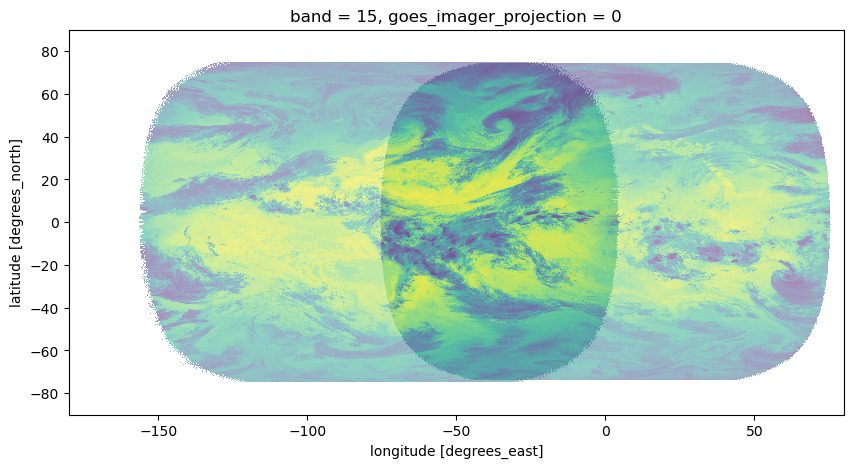

In [32]:
plt.figure(figsize=(10, 5))
msg_ds_reproject.Rad.isel(band=msg_band).plot(alpha=0.5, add_colorbar=False)
goes_ds_reproject.Rad.isel(band=goes_band).plot(alpha=0.5, add_colorbar=False)
plt.ylim(-90, 90)
plt.xlim(-180, 80);

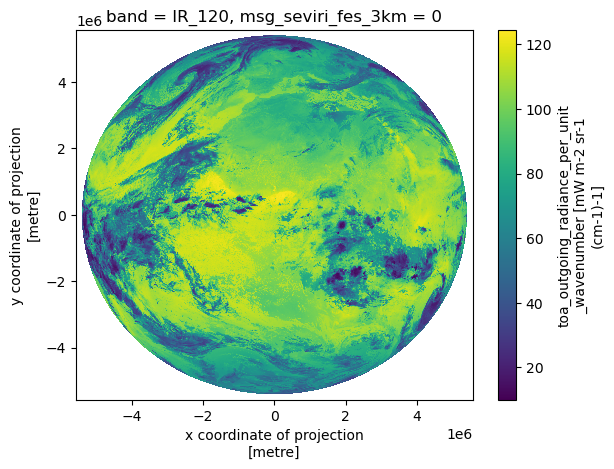

In [100]:
msg_ds.Rad.isel(band=msg_band).plot()

#### Reproject GOES into MSG reference frame

In [102]:
goes_ds_msg = goes_ds.rio.reproject_match(msg_ds)
goes_ds_msg

<xarray.Dataset> Size: 992MB
Dimensions:                 (band: 16, x: 3712, y: 3712)
Coordinates:
  * band                    (band) int64 128B 1 2 3 4 5 6 ... 11 12 13 14 15 16
    goes_imager_projection  int64 8B 0
  * x                       (x) float64 30kB 5.566e+06 5.563e+06 ... -5.569e+06
  * y                       (y) float64 30kB -5.566e+06 -5.563e+06 ... 5.569e+06
Data variables:
    Rad                     (band, y, x) float32 882MB 0.0 0.0 0.0 ... 0.0 0.0
    cloud_mask              (y, x) float64 110MB nan nan nan nan ... nan nan nan
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-01-01T01:09:58.1Z
    time_coverage_start:       2020-01-01T01:00:21.6Z
    time_coverage_end:         2020-01-01T01:09:52.4Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_08_01_01)-6...
    id:                        438b4b74-5233-47d6-8a77-af5ca15f3a0b

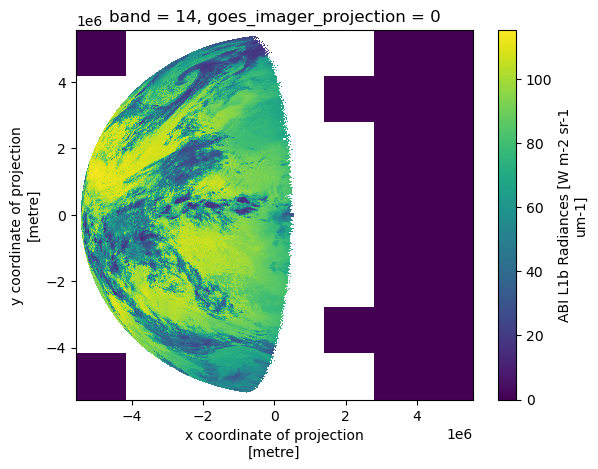

In [35]:
goes_ds_msg.Rad.sel(band=goes_band).plot() # It's not clear why these artifacts are added

#### Clip to common field-of-view

In [103]:
# Extract the bounding boxes of the two datasets
bbox1 = box(*msg_ds.rio.bounds())
bbox2 = box(*goes_ds_msg.rio.bounds())

# Find the intersection of the two bounding boxes
intersection_bbox = bbox1.intersection(bbox2)

In [104]:
out = goes_ds_msg.rio.clip_box(*intersection_bbox.bounds, crs=msg_ds.rio.crs)
out

<xarray.Dataset> Size: 992MB
Dimensions:                 (band: 16, x: 3712, y: 3712)
Coordinates:
  * band                    (band) int64 128B 1 2 3 4 5 6 ... 11 12 13 14 15 16
  * x                       (x) float64 30kB 5.566e+06 5.563e+06 ... -5.569e+06
  * y                       (y) float64 30kB -5.566e+06 -5.563e+06 ... 5.569e+06
    goes_imager_projection  int64 8B 0
Data variables:
    Rad                     (band, y, x) float32 882MB 0.0 0.0 0.0 ... 0.0 0.0
    cloud_mask              (y, x) float64 110MB nan nan nan nan ... nan nan nan
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-01-01T01:09:58.1Z
    time_coverage_start:       2020-01-01T01:00:21.6Z
    time_coverage_end:         2020-01-01T01:09:52.4Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_08_01_01)-6...
    id:                        438b4b74-5233-47d6-8a77-af5ca15f3a0b

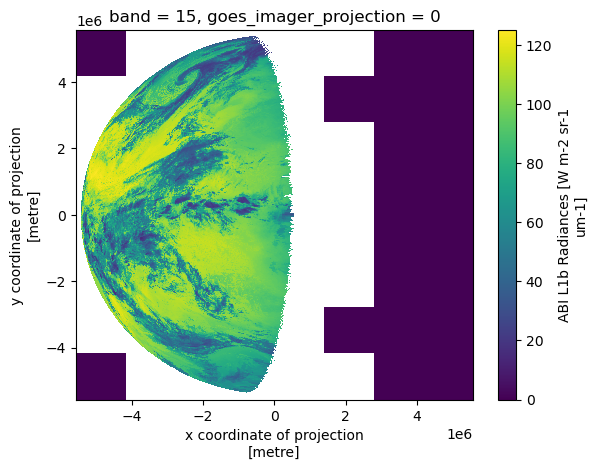

In [38]:
out.Rad.isel(band=goes_band).plot() # Looks the same as before

##### Reproject into EPSG for easier comparison

In [105]:
dst_crs = CRS.from_epsg(4326)  # WGS 84
dst_resolution = 0.027 # in your destination units, in this case degrees
out_reproject = out.rio.reproject(dst_crs=dst_crs, resolution=dst_resolution)
out_reproject

<xarray.Dataset> Size: 2GB
Dimensions:                 (x: 6021, y: 5490, band: 16)
Coordinates:
  * x                       (x) float64 48kB -81.27 -81.24 ... 81.25 81.27
  * y                       (y) float64 44kB 74.16 74.13 74.11 ... -74.02 -74.04
  * band                    (band) int64 128B 1 2 3 4 5 6 ... 11 12 13 14 15 16
    goes_imager_projection  int64 8B 0
Data variables:
    Rad                     (band, y, x) float32 2GB nan nan nan ... nan nan nan
    cloud_mask              (y, x) float64 264MB nan nan nan nan ... nan nan nan
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-01-01T01:09:58.1Z
    time_coverage_start:       2020-01-01T01:00:21.6Z
    time_coverage_end:         2020-01-01T01:09:52.4Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_08_01_01)-6...
    id:                        438b4b74-5233-47d6-8a77-af5ca15f3a0b

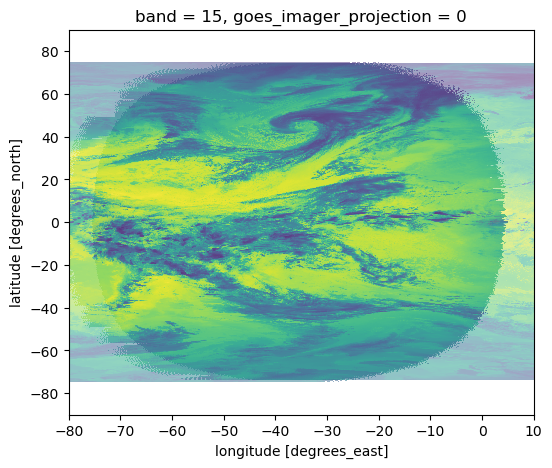

In [115]:
plt.figure(figsize=(6, 5))
msg_ds_reproject.Rad.isel(band=msg_band).plot(alpha=0.5, add_colorbar=False)
goes_ds_reproject.Rad.isel(band=goes_band).plot(alpha=0.5, add_colorbar=False)
out_reproject.Rad.isel(band=goes_band).plot(alpha=0.5, add_colorbar=False)
plt.xlim(-80, 10)
plt.ylim(-90, 90);

#### Clip to limited field-of-view

In [107]:
bounds = out_reproject.rio.bounds()
bounds_clipped = [-60, -60, -15, 60]

In [108]:
bbox = box(*bounds_clipped)

In [109]:
out_clipped = out_reproject.rio.clip_box(*bbox.bounds)
msg_clipped = msg_ds_reproject.rio.clip_box(*bbox.bounds)

(-60.0, 60.0)

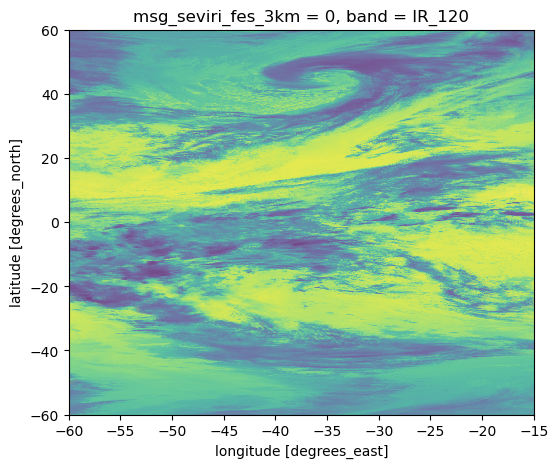

In [110]:
plt.figure(figsize=(6, 5))
out_clipped.Rad.isel(band=goes_band).plot(alpha=0.5, add_colorbar=False)
msg_clipped.Rad.isel(band=msg_band).plot(alpha=0.5, add_colorbar=False)
plt.xlim(-60, -15)
plt.ylim(-60, 60)

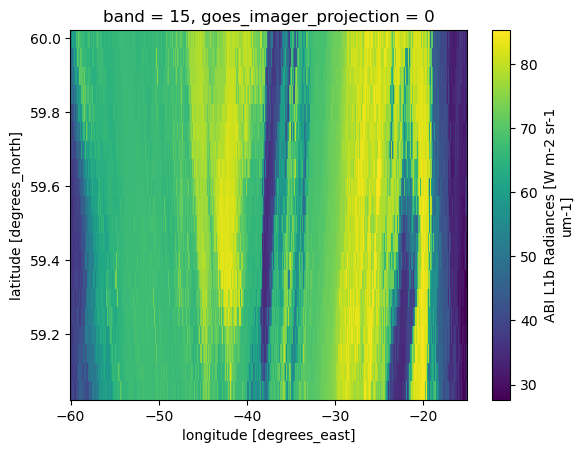

In [128]:
out_clipped.Rad[0:20, 0:20].isel(band=14).plot()

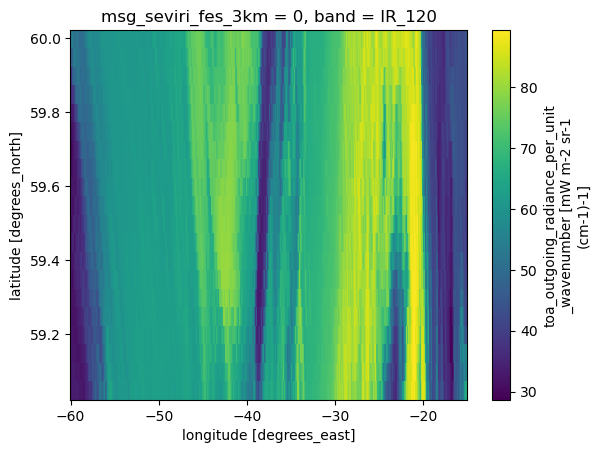

In [126]:
msg_clipped.Rad[0:20, 0:20].isel(band=5).plot()

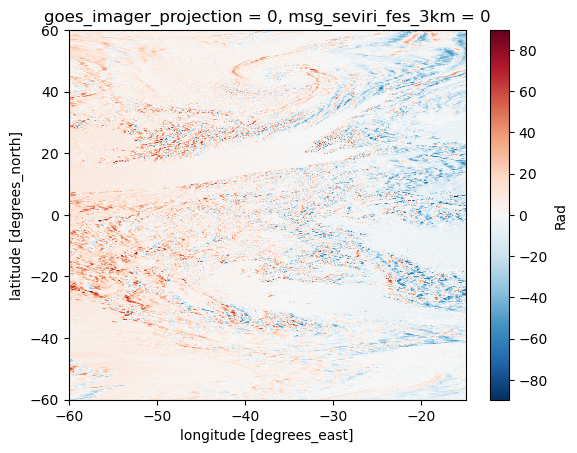

In [112]:
diff = out_clipped.Rad.isel(band=goes_band) - msg_clipped.Rad.isel(band=msg_band)
diff.plot()

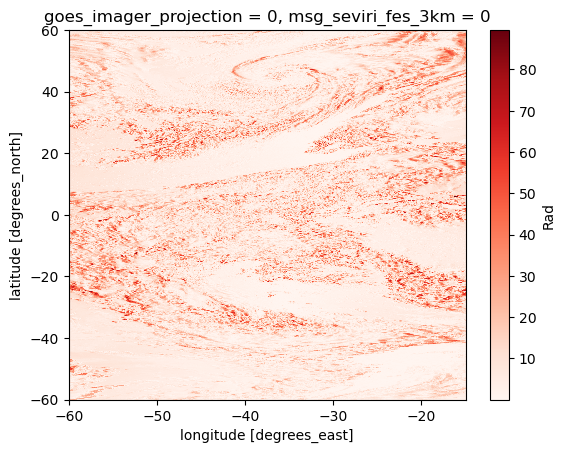

In [114]:
abs = np.abs(diff)
abs.plot(cmap='Reds')